#### Project tasks:
<ol><li>Create an investment portfolio with a high level of returns and relatively low volatility.</li>
    <li>Predict stock prices for the next 5 days with the Monte Carlo method and with ML algorithm.</li></ol>

In [2]:
#import packages
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import seaborn as sns
import pandas_datareader as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## Data import and preparation

Import data from yahoo.

In [3]:
def import_stock_data(tickers, start = '2014-01-01', end='2020-08-31'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start, end=end)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for i in tickers:
            data[i] = wb.DataReader(i, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [4]:
#Create a list of selected tickers 
Tickers = ['AAPL', 'AMZN', 'FB', 'NFLX', 'GOOG', 'GC=F', 'BZ=F']

In [5]:
all_stocks = import_stock_data(Tickers)

Fill NaN values with ffill method: propagate last valid observation forward to the next valid 

In [6]:
all_stocks = all_stocks.ffill()

Calculate the logarithmic daily returns

## Exploratory data analysis

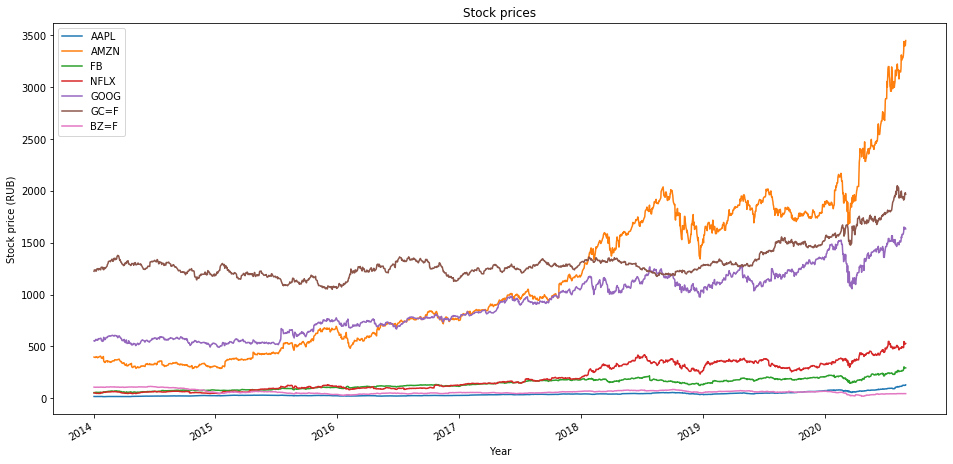

In [8]:
##Let's take a glance on the dataframe

plt.plot(figsize=(16,8))
for i in all_stocks.columns:
    all_stocks[i].plot(label=i, figsize=(16,8))
plt.title('Stock prices')
plt.ylabel('Stock price (RUB)')
plt.xlabel('Year')
plt.legend()
plt.show()

We can suppose that some stocks have a correlation between each other, but the visual analysis doesn't give strong evidence about it. To be more precise in our conclusions we need to process correlation analysis.

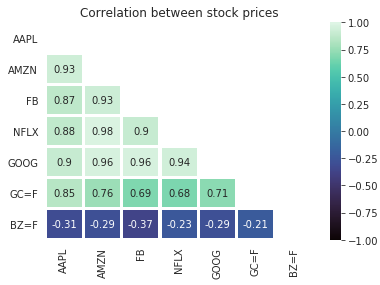

In [9]:
#bottom triangle only
mask = np.zeros_like(all_stocks.corr(method='pearson'))
mask[np.triu_indices_from(mask)] = True
#generate plot
#sns.heatmap(corr_stocks, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
with sns.axes_style("white"):
    # display a correlation heatmap
    ax = sns.heatmap(all_stocks.corr(method='pearson'), mask=mask, annot=True, cmap='mako', vmax=1.0, vmin=-1.0, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.title('Correlation between stock prices')
plt.show()

As we can see from the graph "Correlation between stock prices" FAANG stocks have a strong positive correlation between each other. On the other hand, oil prices have a relatively small negative correlation with other financial tools.

Also, we need to check the distribution of the logarithmic return of the stocks. We plot it to investigate what is the level of volatility of the analyzing financial tools. As we can see on the charts below some financial tools have relatively bigger volatility than others (for example NFLX has a lower level of variance then AAPL and AMZN). It will be useful when we will start to build an investment portfolio and volatility-profit trade-off will appear.

In [10]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [11]:
daily_returns = log_returns(all_stocks)

In [12]:
def cool_plots(data, col):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,2,1)
    sns.boxplot(data[col])
    plt.title('Box plot of {}'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.subplot(2,2,2)
    sns.distplot(data[col])
    plt.title('{} distribution'.format(col), fontsize=20)
    plt.xlabel(col)
    plt.ylabel('% of all')
    plt.subplots_adjust(bottom=0.25, top=0.75)
    plt.show()

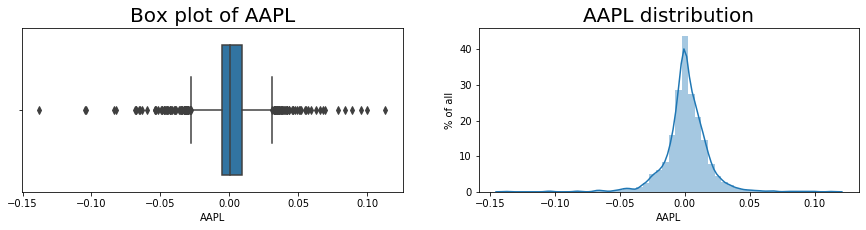

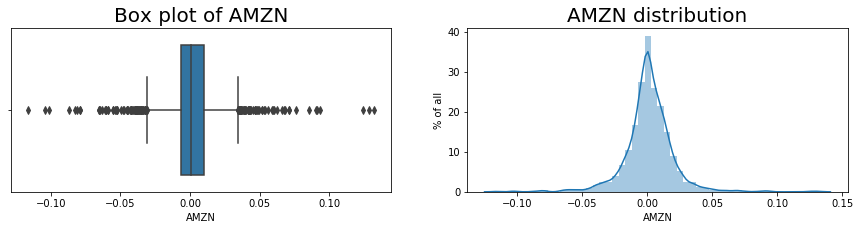

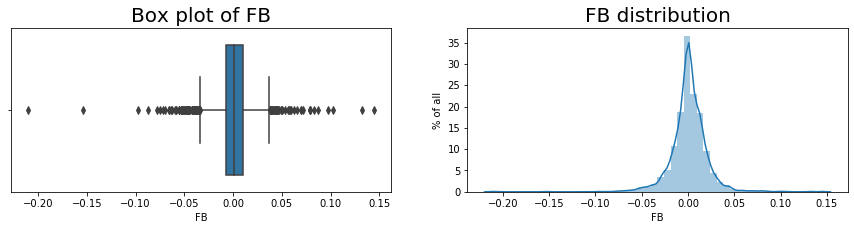

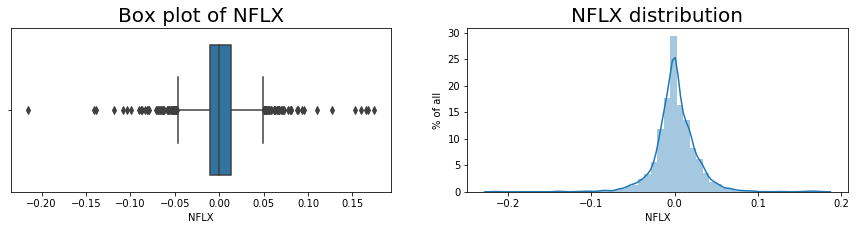

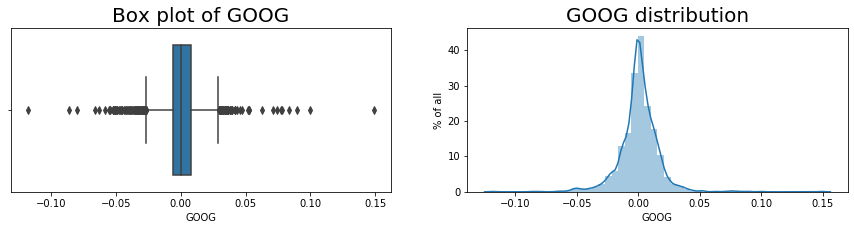

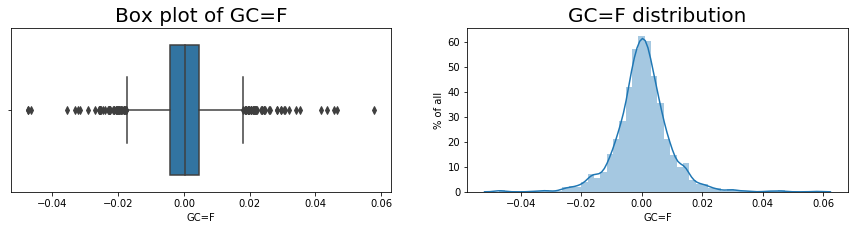

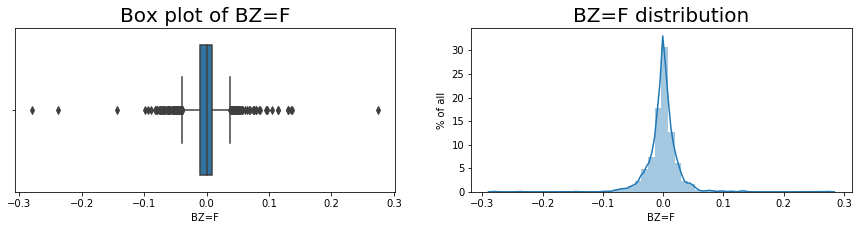

In [13]:
for col in daily_returns.columns:
        cool_plots(daily_returns, col)

## Task 1. Define a portfolio structure
We need to define an optimal portfolio structure based on financial tools' daily profit and volitation. We can't use the logarithmic returns here because it doesn't work right with weights. Thus for this segment, we will deal with simple (discrete) returns.

In [14]:
simple_returns_daily=all_stocks.pct_change()

In [15]:
av_returns = simple_returns_daily.mean()
cov_returns = simple_returns_daily.cov()
std_returns = simple_returns_daily.std()

#### Generate weights for 10000 portfolios

In [17]:
#generate weights
weights = None
weights = pd.DataFrame(np.random.randint(0,100,size=(10000, 7)), columns=simple_returns_daily.columns)

In [18]:
#normalize weights as sum must be = 1
weights=weights.div(weights.sum(axis=1), axis=0)

#### Calculate returns on portfolios

In [20]:
#calculate returns by applying weights
#to have yearly return *252
portfolios_returns = (weights.AAPL*av_returns['AAPL']+weights.AMZN*av_returns['AMZN']+weights['BZ=F']*av_returns['BZ=F']+weights.FB*av_returns['FB']+weights['GC=F']*av_returns['GC=F']+weights.GOOG*av_returns['GOOG']+weights.NFLX*av_returns['NFLX']  )*252

In [21]:
portfolios_returns = pd.DataFrame(portfolios_returns, columns=['returns'])

#### Volatility on portfolios

In [61]:
portfolio_std = pd.DataFrame({'key1': [], 'STD': []})
for i in range(10000):
    std=np.sqrt(np.dot(weights.iloc[i].T,np.dot(cov_returns, weights.iloc[i]))) * np.sqrt(252)
    portfolio_std = portfolio_std.append({'key1': i, 'STD': std}, ignore_index=True)

Text(0, 0.5, 'Returns')

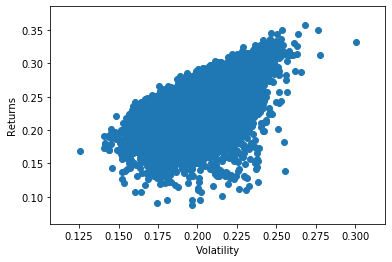

In [24]:
plt.scatter(portfolio_std.STD,portfolios_returns, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')

#### Find the optimal portfolio structure

In [25]:
result = pd.merge(portfolio_std, portfolios_returns, how='inner', left_index=True, right_index=True)

Sort merged dataframe by 'returns' column

In [26]:
result = result.sort_values(by=['returns'], axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False)

From the top 5 portfolios with the largest returns let's find a case with the smallest standard deviation.

In [27]:
opt_portf = result.loc[:5,'STD'].idxmin()

In [28]:
portfolios_returns.iloc[opt_portf]

returns    0.284815
Name: 8664, dtype: float64

In [29]:
portfolio_std.iloc[opt_portf]

key1    8664.000000
STD        0.193327
Name: 8664, dtype: float64

This portfolio was chosen from the top 5 most profitable options but with the smallest variance among them.
The structure of the selected portfolio was:

In [30]:
weights.iloc[opt_portf]

AAPL    0.257703
AMZN    0.156863
FB      0.067227
NFLX    0.254902
GOOG    0.000000
GC=F    0.263305
BZ=F    0.000000
Name: 8664, dtype: float64

## Task 2 Build a forecast for the stock returns

### Monte Carlo method
For this segment we will use The Brownian  equtations:
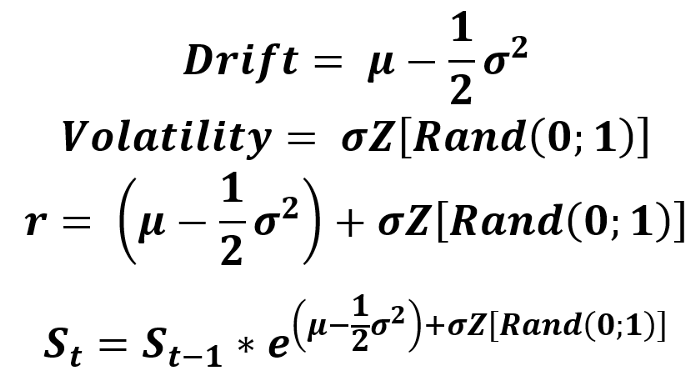
You can find more here https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

First of all let's create a function for drift computations

In [31]:
def drift_val(data):
    lr = log_returns(data)
    drift = lr.mean()-(0.5*lr.var())
    return drift

In [32]:
drifts_list = []
for i in all_stocks.columns:
    drifts_list.append(drift_val(all_stocks[i]))

In [33]:
drifts_list = np.array(drifts_list)

In [34]:
drifts = pd.DataFrame(dict(zip(all_stocks.columns, drifts_list)), index=[0])

#### AAPL stock price simulation

In [35]:
daily_prof_AAPL = np.exp(log_returns(all_stocks['AAPL']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['AAPL'].values)
prediction_AAPL = np.zeros_like(daily_prof_AAPL)
prediction_AAPL[0]=all_stocks.iloc[-1,0]
for d in range(1,5):
    prediction_AAPL[d]=prediction_AAPL[d-1]*daily_prof_AAPL[d]

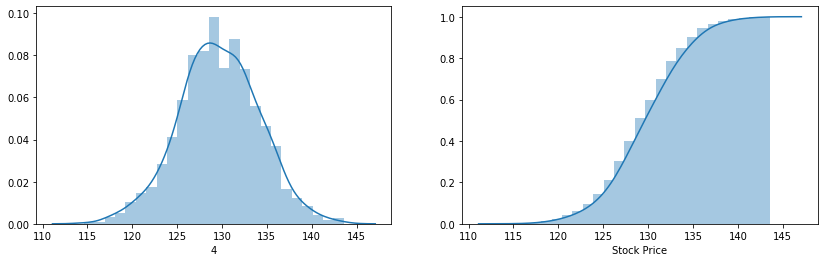

Days: 5
Expected Value: $129.66
Return: 0.48%


In [36]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_AAPL).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_AAPL).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_AAPL).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_AAPL).iloc[-1].mean()-prediction_AAPL[0,1])/pd.DataFrame(prediction_AAPL).iloc[-1].mean(),2)}%")


#### AMZN stock price simulation

In [37]:
daily_prof_AMZN = np.exp(log_returns(all_stocks['AMZN']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['AMZN'].values)
prediction_AMZN = np.zeros_like(daily_prof_AMZN)
prediction_AMZN[0]=all_stocks.iloc[-1,1]
for d in range(1,5):
    prediction_AMZN[d]=prediction_AMZN[d-1]*daily_prof_AMZN[d]

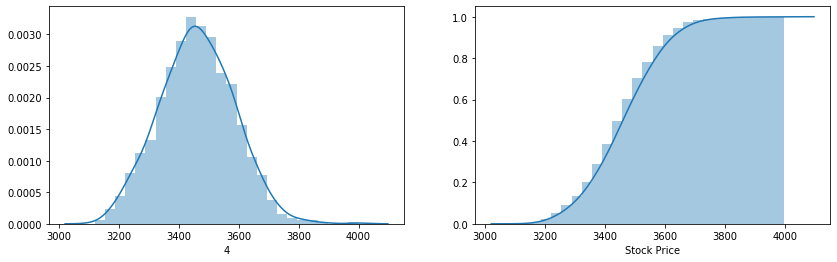

Days: 5
Expected Value: $3460.91
Return: 0.29%


In [38]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_AMZN).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_AMZN).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_AMZN).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_AMZN).iloc[-1].mean()-prediction_AMZN[0,1])/pd.DataFrame(prediction_AMZN).iloc[-1].mean(),2)}%")  

#### FB stock price simulation

In [39]:
daily_prof_FB = np.exp(log_returns(all_stocks['FB']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['FB'].values)
prediction_FB = np.zeros_like(daily_prof_FB)
prediction_FB[0]=all_stocks.iloc[-1,2]
for d in range(1,5):
    prediction_FB[d]=prediction_FB[d-1]*daily_prof_FB[d]

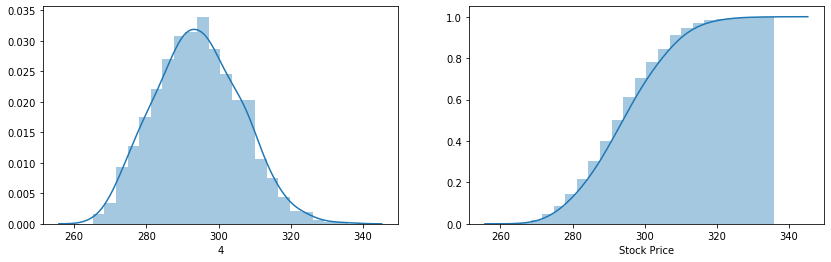

Days: 5
Expected Value: $294.24
Return: 0.35%


In [40]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_FB).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_FB).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_FB).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_FB).iloc[-1].mean()-prediction_FB[0,1])/pd.DataFrame(prediction_FB).iloc[-1].mean(),2)}%")


#### NFLX stock price simulation

In [41]:
daily_prof_NFLX = np.exp(log_returns(all_stocks['NFLX']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['NFLX'].values)
prediction_NFLX = np.zeros_like(daily_prof_NFLX)
prediction_NFLX[0]=all_stocks.iloc[-1,3]
for d in range(1,5):
    prediction_NFLX[d]=prediction_NFLX[d-1]*daily_prof_NFLX[d]

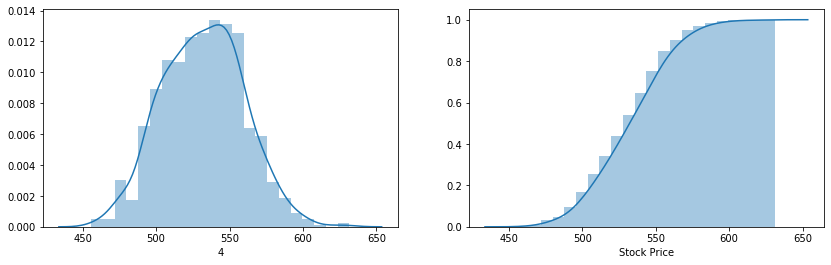

Days: 5
Expected Value: $531.96
Return: 0.45%


In [42]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_NFLX).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_NFLX).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_NFLX).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_NFLX).iloc[-1].mean()-prediction_NFLX[0,1])/pd.DataFrame(prediction_NFLX).iloc[-1].mean(),2)}%")

#### GOOG stock price simulation

In [43]:
daily_prof_GOOG = np.exp(log_returns(all_stocks['GOOG']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['GOOG'].values)
prediction_GOOG = np.zeros_like(daily_prof_GOOG)
prediction_GOOG[0]=all_stocks.iloc[-1,4]
for d in range(1,5):
    prediction_GOOG[d]=prediction_GOOG[d-1]*daily_prof_GOOG[d]

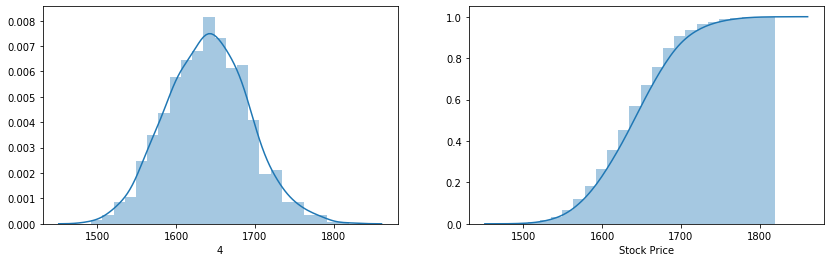

Days: 5
Expected Value: $1640.32
Return: 0.37%


In [44]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_GOOG).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_GOOG).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_GOOG).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_GOOG).iloc[-1].mean()-prediction_GOOG[0,1])/pd.DataFrame(prediction_GOOG).iloc[-1].mean(),2)}%")

#### GC=F stock price simulation

In [45]:
daily_prof_GC_F = np.exp(log_returns(all_stocks['GC=F']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['GC=F'].values)
prediction_GC_F = np.zeros_like(daily_prof_GC_F)
prediction_GC_F[0]=all_stocks.iloc[-1,5]
for d in range(1,5):
    prediction_GC_F[d]=prediction_GC_F[d-1]*daily_prof_GC_F[d]

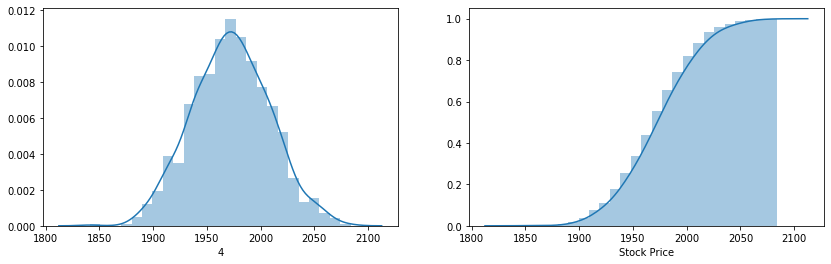

Days: 30
Expected Value: $1972.59
Return: 0.25%


In [46]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_GC_F).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_GC_F).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {30}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_GC_F).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_GC_F).iloc[-1].mean()-prediction_GC_F[0,1])/pd.DataFrame(prediction_GC_F).iloc[-1].mean(),2)}%")

#### BZ=F stock price simulation

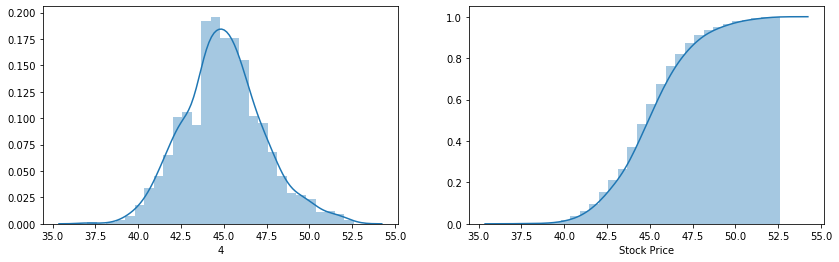

Days: 5
Expected Value: $44.99
Return: -0.25%


In [47]:
daily_prof_BZ_F = np.exp(log_returns(all_stocks['BZ=F']).std()*norm.ppf(np.random.rand(5, 1000))+drifts['BZ=F'].values)
prediction_BZ_F = np.zeros_like(daily_prof_BZ_F)
prediction_BZ_F[0]=all_stocks.iloc[-1,6]
for d in range(1,5):
    prediction_BZ_F[d]=prediction_BZ_F[d-1]*daily_prof_BZ_F[d]







fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(pd.DataFrame(prediction_BZ_F).iloc[-1], ax=ax[0])
sns.distplot(pd.DataFrame(prediction_BZ_F).iloc[-1], hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
plt.show()

print(f"Days: {5}")
print(f"Expected Value: ${round(pd.DataFrame(prediction_BZ_F).iloc[-1].mean(),2)}")
print(f"Return: {round(100*(pd.DataFrame(prediction_BZ_F).iloc[-1].mean()-prediction_BZ_F[0,1])/pd.DataFrame(prediction_BZ_F).iloc[-1].mean(),2)}%")

## ML Prediction

Create columns with shifted data

In [48]:
def shifted_data(df, forecast_out=5):
    #set how many days in the future we predict
    for i in df.columns:
        df['Forecast_'+i] = df[[i]].shift(-forecast_out)
    return df

In [49]:
data_for_prediction = shifted_data(all_stocks)[:-5].reset_index()

In [50]:
#split data to training 80% and testing 20%
x_train_AAPL, x_test_AAPL,y_train_AAPL,y_test_AAPL=train_test_split(np.array(data_for_prediction.loc[:,['AAPL']]), data_for_prediction['Forecast_AAPL'], test_size=0.2)
x_train_AMZN, x_test_AMZN,y_train_AMZN,y_test_AMZN=train_test_split(data_for_prediction.loc[:,['AMZN']], data_for_prediction['Forecast_AMZN'], test_size=0.2)
x_train_FB, x_test_FB,y_train_FB,y_test_FB=train_test_split(data_for_prediction.loc[:,['FB']], data_for_prediction['Forecast_FB'], test_size=0.2)
x_train_NFLX, x_test_NFLX,y_train_NFLX,y_test_NFLX=train_test_split(data_for_prediction.loc[:,['NFLX']], data_for_prediction['Forecast_NFLX'], test_size=0.2)
x_train_GOOG, x_test_GOOG,y_train_GOOG,y_test_GOOG=train_test_split(data_for_prediction.loc[:,['GOOG']], data_for_prediction['Forecast_GOOG'], test_size=0.2)
x_train_GC_F, x_test_GC_F,y_train_GC_F,y_test_GC_F=train_test_split(data_for_prediction.loc[:,['GC=F']], data_for_prediction['Forecast_GC=F'], test_size=0.2)
x_train_BZ_F, x_test_BZ_F,y_train_BZ_F,y_test_BZ_F=train_test_split(data_for_prediction.loc[:,['BZ=F']], data_for_prediction['Forecast_BZ=F'], test_size=0.2)

For this section we will use the simplest one ML algorithm - Linear Regression.

#### Prediction AAPL

In [51]:
x_forecast_AAPL=np.array(all_stocks[['AAPL']])[-5:]
x_forecast_AMZN=np.array(all_stocks[['AMZN']])[-5:]
x_forecast_FB=np.array(all_stocks[['FB']])[-5:]
x_forecast_NFLX=np.array(all_stocks[['NFLX']])[-5:]
x_forecast_GOOG=np.array(all_stocks[['GOOG']])[-5:]
x_forecast_GC=np.array(all_stocks[['GC=F']])[-5:]
x_forecast_BZ=np.array(all_stocks[['BZ=F']])[-5:]

In [52]:
#create and train linear regression model
lr_AAPL = LinearRegression()
lr_AAPL = lr_AAPL.fit(x_train_AAPL,y_train_AAPL)

lr_AMZN = LinearRegression()
lr_AMZN = lr_AMZN.fit(x_train_AMZN,y_train_AMZN)

lr_FB = LinearRegression()
lr_FB = lr_FB.fit(x_train_FB,y_train_FB)

lr_NFLX = LinearRegression()
lr_NFLX = lr_NFLX.fit(x_train_NFLX,y_train_NFLX)

lr_GOOG = LinearRegression()
lr_GOOG = lr_GOOG.fit(x_train_GOOG,y_train_GOOG)

lr_GC_F = LinearRegression()
lr_GC_F = lr_GC_F.fit(x_train_GC_F,y_train_GC_F)

lr_BZ_F = LinearRegression()
lr_BZ_F = lr_GC_F.fit(x_train_BZ_F,y_train_BZ_F)

In [53]:
#check how good model is using R^2
lr_conf_AAPL=lr_AAPL.score(x_test_AAPL,y_test_AAPL)
print("lr confidence for AAPL",lr_conf_AAPL)

lr_conf_AMZN=lr_AMZN.score(x_test_AMZN,y_test_AMZN)
print("lr confidence for AMZN",lr_conf_AMZN)

lr_conf_FB=lr_FB.score(x_test_FB,y_test_FB)
print("lr confidence for FB",lr_conf_FB)

lr_conf_NFLX=lr_NFLX.score(x_test_NFLX,y_test_NFLX)
print("lr confidence for NFLX",lr_conf_NFLX)

lr_conf_GOOG=lr_GOOG.score(x_test_GOOG,y_test_GOOG)
print("lr confidence for GOOG",lr_conf_GOOG)

lr_conf_GC_F=lr_GC_F.score(x_test_GC_F,y_test_GC_F)
print("lr confidence for GC=F",lr_conf_GC_F)

lr_conf_BZ_F=lr_BZ_F.score(x_test_BZ_F,y_test_BZ_F)
print("lr confidence for BZ=F",lr_conf_BZ_F)

lr confidence for AAPL 0.9913017868830464
lr confidence for AMZN 0.9921843781267349
lr confidence for FB 0.981668407622511
lr confidence for NFLX 0.9903318846252062
lr confidence for GOOG 0.984148759024664
lr confidence for GC=F 0.9587239535789516
lr confidence for BZ=F 0.9818039145494396


In [54]:
#Prediction for the Adj Close
lr_predict_AAPL=lr_AAPL.predict(x_forecast_AAPL)
lr_predict_AMZN=lr_AMZN.predict(x_forecast_AMZN)
lr_predict_FB=lr_FB.predict(x_forecast_FB)
lr_predict_NFLX=lr_NFLX.predict(x_forecast_NFLX)
lr_predict_GOOG=lr_GOOG.predict(x_forecast_GOOG)
lr_predict_GC_F=lr_GC_F.predict(x_forecast_GC)
lr_predict_BZ_F=lr_BZ_F.predict(x_forecast_BZ)

COMPARING RESULTS

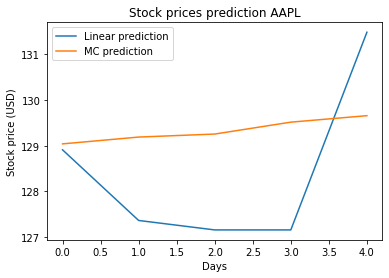

In [55]:
##AAPL PREDICTION

plt.plot(lr_predict_AAPL, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_AAPL).T.mean(), label='MC prediction')
plt.title('Stock prices prediction AAPL')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()

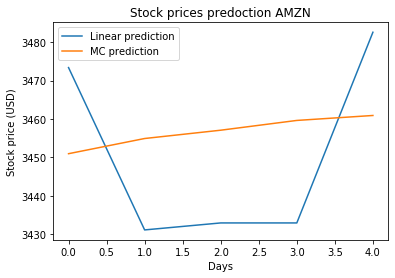

In [56]:
##AMZN PREDICTION

plt.plot(figsize=(16,8))
plt.plot(lr_predict_AMZN, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_AMZN).T.mean(), label='MC prediction')
plt.title('Stock prices predoction AMZN')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()

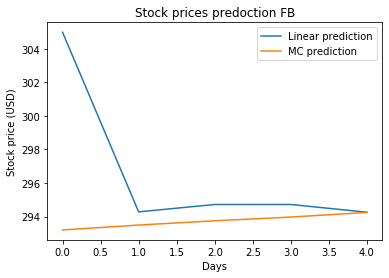

In [57]:
##FB PREDICTION

plt.plot(figsize=(16,8))
plt.plot(lr_predict_FB, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_FB).T.mean(), label='MC prediction')
plt.title('Stock prices predoction FB')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()

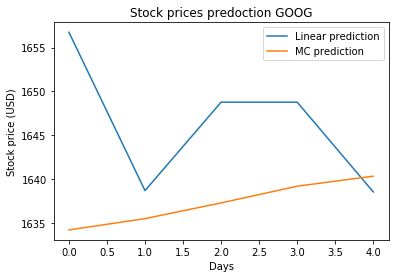

In [58]:
##GOOG PREDICTION

plt.plot(figsize=(16,8))
plt.plot(lr_predict_GOOG, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_GOOG).T.mean(), label='MC prediction')
plt.title('Stock prices predoction GOOG')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()

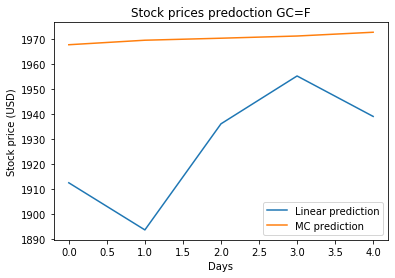

In [59]:
##GC=F PREDICTION

plt.plot(figsize=(16,8))
plt.plot(lr_predict_GC_F, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_GC_F).T.mean(), label='MC prediction')
plt.title('Stock prices predoction GC=F')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()

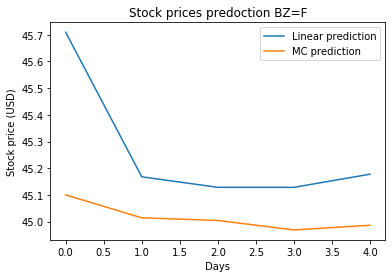

In [60]:
##GC=F PREDICTION

plt.plot(figsize=(16,8))
plt.plot(lr_predict_BZ_F, label='Linear prediction')
plt.plot(pd.DataFrame(prediction_BZ_F).T.mean(), label='MC prediction')
plt.title('Stock prices predoction BZ=F')
plt.ylabel('Stock price (USD)')
plt.xlabel('Days')
plt.legend()
plt.show()